## Importing the Necessary Libraries 

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os, shutil

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix

---

## Loading the Dataset
The dataset already splits to three folders test, train and validation. Each folder has 2 Subfolders which are Normal and Pneumonia. Inside of these folders there are chest-Xrays of peopel with diagnosed of Pneumonia and peopel with Normal lung. 

fter loading and craeting the first simple model, we saw a strange behavior on graph from validation accuracy and validation loss. This unusual behavior is caused by the number of validation folders. In the otiginal folders, there are only 16 images inisde the folder and this is causing a Roller coasters behavior from validation accuracy and validation loss. 

I added equal number of images into both Pneumonia and Normal folders. Then make new simple model. 

In [3]:
#giving pathway to load data.
test_folder = '../data/test/'
train_folder = '../data/train/'
val_folder = '../data/val/'

------

# Data Augmentation
Dealing with data imbalance with chaning features of our images.

In [193]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_folder,
                                                        target_size=(150, 150),
                                                        batch_size=15,
                                                        class_mode='binary')


Found 5133 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [194]:
# create the data sets
train, train_lables = next(train_generator)
test, test_labels = next(test_generator)
val, val_labels = next(validation_generator)

In [195]:
# getting shape of our images 
print(train.shape)
print(test.shape)
print(val.shape)

(20, 150, 150, 3)
(50, 150, 150, 3)
(15, 150, 150, 3)


-----

# Making first simple model
- adding input layer
- flatten layer
- output layer

In [131]:
# Build a baseline fully connected model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [51]:
# fitting model in training set
fsm = model.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              )

Epoch 1/20
50/50 [==============================] - 15s 308ms/step - loss: 0.8333 - acc: 0.7250 - val_loss: 1.4188 - val_acc: 0.5098
Epoch 2/20
50/50 [==============================] - 14s 289ms/step - loss: 0.4220 - acc: 0.8230 - val_loss: 0.3356 - val_acc: 0.8333
Epoch 3/20
50/50 [==============================] - 15s 304ms/step - loss: 0.3425 - acc: 0.8480 - val_loss: 0.2826 - val_acc: 0.9118
Epoch 4/20
50/50 [==============================] - 15s 296ms/step - loss: 0.2593 - acc: 0.8900 - val_loss: 0.3022 - val_acc: 0.8725
Epoch 5/20
50/50 [==============================] - 15s 297ms/step - loss: 0.2424 - acc: 0.9050 - val_loss: 0.2136 - val_acc: 0.9314
Epoch 6/20
50/50 [==============================] - 15s 300ms/step - loss: 0.2019 - acc: 0.9210 - val_loss: 0.8736 - val_acc: 0.6765
Epoch 7/20
50/50 [==============================] - 15s 295ms/step - loss: 0.1771 - acc: 0.9240 - val_loss: 0.2098 - val_acc: 0.9314
Epoch 8/20
50/50 [==============================] - 16s 314ms/step - 

In [52]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
flatten_7 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 700929    
Total params: 701,825
Trainable params: 701,825
Non-trainable params: 0
_________________________________________________________________


In [132]:
# running test set to see the accuracy 
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=50, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
13/13 [==============================] - 5s 386ms/step - loss: 0.6898 - acc: 0.6186
test acc: 0.6185897588729858


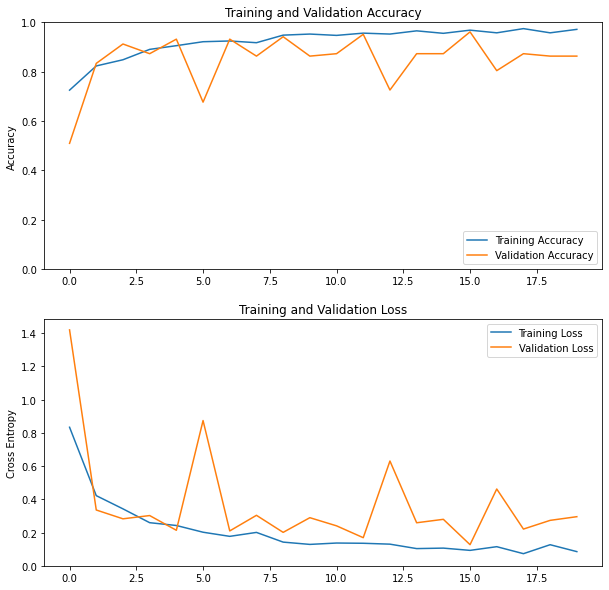

In [155]:
# Plot model
acc = fsm.history['acc']
val_acc = fsm.history['val_acc']

loss = fsm.history['loss']
val_loss = fsm.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(plt.ylim()), 1])
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,max(plt.ylim())])
ax[1].set_title('Training and Validation Loss')
plt.savefig('first-val-acc')
plt.show()

In [129]:
# using the same baseline connected model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [62]:
# changing steps to see the different result 
fsm_1 = model.fit_generator(train_generator, 
                              steps_per_epoch=20, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              )

Epoch 1/20
20/20 [==============================] - 7s 349ms/step - loss: 1.2559 - acc: 0.6850 - val_loss: 0.5641 - val_acc: 0.6667
Epoch 2/20
20/20 [==============================] - 6s 316ms/step - loss: 0.6177 - acc: 0.7675 - val_loss: 0.6086 - val_acc: 0.6275
Epoch 3/20
20/20 [==============================] - 6s 316ms/step - loss: 0.5799 - acc: 0.8000 - val_loss: 0.4239 - val_acc: 0.7745
Epoch 4/20
20/20 [==============================] - 7s 327ms/step - loss: 0.4991 - acc: 0.7875 - val_loss: 0.3522 - val_acc: 0.8824
Epoch 5/20
20/20 [==============================] - 7s 329ms/step - loss: 0.3930 - acc: 0.8275 - val_loss: 0.3232 - val_acc: 0.8922
Epoch 6/20
20/20 [==============================] - 6s 309ms/step - loss: 0.4387 - acc: 0.8372 - val_loss: 0.4230 - val_acc: 0.7647
Epoch 7/20
20/20 [==============================] - 6s 322ms/step - loss: 0.3202 - acc: 0.8550 - val_loss: 0.4040 - val_acc: 0.7941
Epoch 8/20
20/20 [==============================] - 6s 314ms/step - loss: 0.

In [63]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
flatten_10 (Flatten)         (None, 700928)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 700929    
Total params: 701,825
Trainable params: 701,825
Non-trainable params: 0
_________________________________________________________________


In [130]:
# running test set again with new model
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=50, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
13/13 [==============================] - 5s 405ms/step - loss: 0.6646 - acc: 0.6554
test acc: 0.6554487347602844


## little improvement in accuracy, but it's not enough.

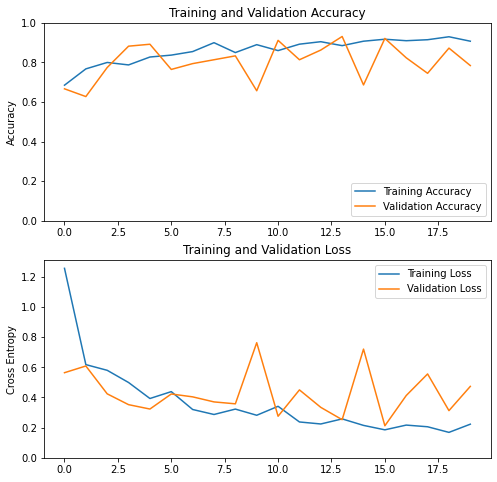

In [64]:
# plot model
acc = fsm_1.history['acc']
val_acc = fsm_1.history['val_acc']

loss = fsm_1.history['loss']
val_loss = fsm_1.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(plt.ylim()), 1])
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,max(plt.ylim())])
ax[1].set_title('Training and Validation Loss')
#plt.savefig('first-val-acc')
plt.show();


----

# Build a CNN

In this model, we add more hidden layers( Conv2D, Maxpooling 2D) to make our model's performance. 

In [126]:
# making more layers with Conv and Maxpooling
# still keep those Dense and Flatten layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [65]:
# fitting our training with the CNN model
new_model = model.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              )

Epoch 1/20
50/50 [==============================] - 15s 297ms/step - loss: 0.1786 - acc: 0.9250 - val_loss: 0.2994 - val_acc: 0.8627
Epoch 2/20
50/50 [==============================] - 15s 303ms/step - loss: 0.1650 - acc: 0.9380 - val_loss: 0.6222 - val_acc: 0.7255
Epoch 3/20
50/50 [==============================] - 15s 299ms/step - loss: 0.1510 - acc: 0.9450 - val_loss: 0.4214 - val_acc: 0.7941
Epoch 4/20
50/50 [==============================] - 15s 303ms/step - loss: 0.1404 - acc: 0.9450 - val_loss: 0.3140 - val_acc: 0.8529
Epoch 5/20
50/50 [==============================] - 15s 295ms/step - loss: 0.1076 - acc: 0.9560 - val_loss: 0.3234 - val_acc: 0.8529
Epoch 6/20
50/50 [==============================] - 15s 296ms/step - loss: 0.1392 - acc: 0.9527 - val_loss: 0.2604 - val_acc: 0.8824
Epoch 7/20
50/50 [==============================] - 15s 297ms/step - loss: 0.1149 - acc: 0.9567 - val_loss: 0.1429 - val_acc: 0.9510
Epoch 8/20
50/50 [==============================] - 15s 304ms/step - 

In [127]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 15, 15, 128)     

In [128]:
# running test set
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=50, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
13/13 [==============================] - 7s 514ms/step - loss: 0.6887 - acc: 0.6250
test acc: 0.625


## Our accuracy dropped little bit wwhich was expected. This new model needs tuning to make it better.

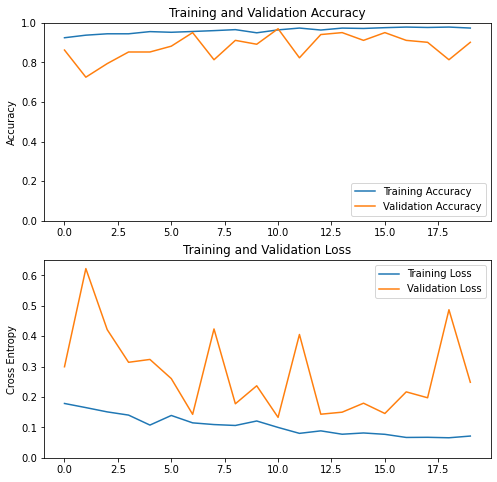

In [66]:
# plot model
acc = new_model.history['acc']
val_acc = new_model.history['val_acc']

loss = new_model.history['loss']
val_loss = new_model.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(plt.ylim()), 1])
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,max(plt.ylim())])
ax[1].set_title('Training and Validation Loss')
#plt.savefig('first-val-acc')
plt.show();

## The Second CNN will use the same model, but different steps and epochs.

In [134]:
# using the same first CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [80]:
# fitting our training with the CNN model
# changing steps and epochs
new_model_1 = new_model = model.fit_generator(train_generator, 
                              steps_per_epoch=20, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              )

Epoch 1/30
20/20 [==============================] - 8s 424ms/step - loss: 0.1429 - acc: 0.9500 - val_loss: 0.4771 - val_acc: 0.8039
Epoch 2/30
20/20 [==============================] - 8s 414ms/step - loss: 0.1070 - acc: 0.9650 - val_loss: 0.4063 - val_acc: 0.8235
Epoch 3/30
20/20 [==============================] - 8s 408ms/step - loss: 0.1006 - acc: 0.9650 - val_loss: 0.1972 - val_acc: 0.9118
Epoch 4/30
20/20 [==============================] - 8s 413ms/step - loss: 0.1108 - acc: 0.9575 - val_loss: 0.1793 - val_acc: 0.9314
Epoch 5/30
20/20 [==============================] - 8s 419ms/step - loss: 0.1310 - acc: 0.9575 - val_loss: 0.1765 - val_acc: 0.9314
Epoch 6/30
20/20 [==============================] - 8s 414ms/step - loss: 0.1136 - acc: 0.9575 - val_loss: 0.1828 - val_acc: 0.9412
Epoch 7/30
20/20 [==============================] - 9s 428ms/step - loss: 0.1306 - acc: 0.9400 - val_loss: 0.1672 - val_acc: 0.9510
Epoch 8/30
20/20 [==============================] - 8s 408ms/step - loss: 0.

In [135]:
# running test set
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=50, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
13/13 [==============================] - 7s 517ms/step - loss: 0.7035 - acc: 0.3750
test acc: 0.375


## After we ran the second CNN model, we got the worst accuracy so far. These means that we need to change our model. 

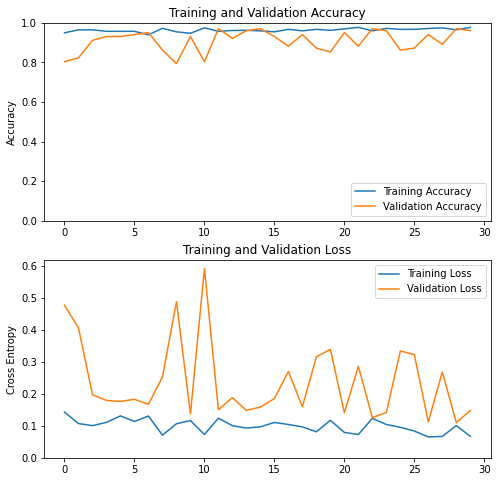

In [81]:
# plot model
acc = new_model_1.history['acc']
val_acc = new_model_1.history['val_acc']

loss = new_model_1.history['loss']
val_loss = new_model_1.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(plt.ylim()), 1])
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,max(plt.ylim())])
ax[1].set_title('Training and Validation Loss')
#plt.savefig('first-val-acc')
plt.show();

____

# Adding EarlyStopping into our model.


- A problem with training neural networks is in the choice of the number of training epochs to use as you can see in the last model.
- Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [210]:
# Instantiate EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=0, verbose=1,
                           mode='min')

In [211]:
# using the same CNN model
# adding early stop after compiling model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=0, verbose=1,
                           mode='min')

In [212]:
# fitting our training with the CNN model and early stop
new_model_stop = new_model = model.fit_generator(train_generator, 
                              steps_per_epoch=30, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              )

Epoch 1/20
30/30 [==============================] - 13s 430ms/step - loss: 0.5495 - acc: 0.7533 - val_loss: 0.7021 - val_acc: 0.5098
Epoch 2/20
30/30 [==============================] - 13s 441ms/step - loss: 0.5332 - acc: 0.7467 - val_loss: 0.5538 - val_acc: 0.7059
Epoch 3/20
30/30 [==============================] - 14s 454ms/step - loss: 0.4275 - acc: 0.8150 - val_loss: 0.4401 - val_acc: 0.7745
Epoch 4/20
30/30 [==============================] - 13s 441ms/step - loss: 0.3110 - acc: 0.8651 - val_loss: 0.4507 - val_acc: 0.7451
Epoch 5/20
30/30 [==============================] - 14s 477ms/step - loss: 0.2730 - acc: 0.8883 - val_loss: 0.5756 - val_acc: 0.7157
Epoch 6/20
30/30 [==============================] - 14s 464ms/step - loss: 0.2795 - acc: 0.8783 - val_loss: 0.5948 - val_acc: 0.7157
Epoch 7/20
30/30 [==============================] - 14s 454ms/step - loss: 0.1930 - acc: 0.9250 - val_loss: 0.3045 - val_acc: 0.8529
Epoch 8/20
30/30 [==============================] - 14s 462ms/step - 

In [213]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 15, 15, 128)     

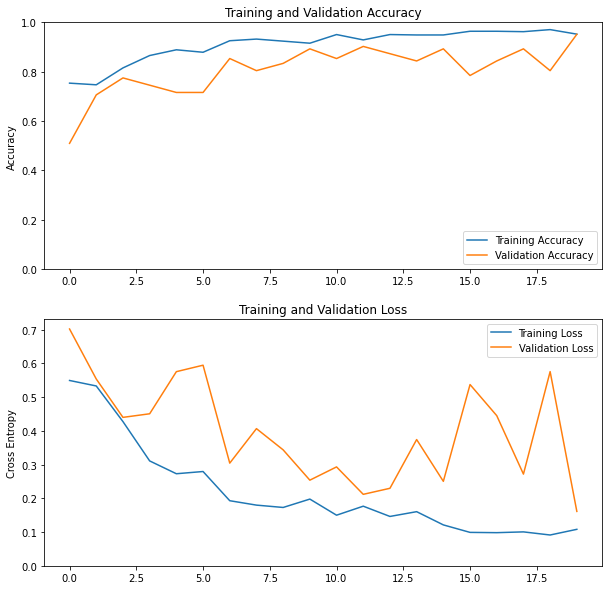

In [214]:
#plot model
acc = new_model_stop.history['acc']
val_acc = new_model_stop.history['val_acc']

loss = new_model_stop.history['loss']
val_loss = new_model_stop.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(plt.ylim()), 1])
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,max(plt.ylim())])
ax[1].set_title('Training and Validation Loss')
plt.savefig('final-val-acc')
plt.show();

## After tuning early stop and making changes in that, we got the final accuracy score.

In [215]:
# Running test set 
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=50, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
13/13 [==============================] - 6s 498ms/step - loss: 0.5581 - acc: 0.8061
test acc: 0.8060897588729858


In [224]:
# Using all images in test folder to run model in test set
# increasing batch size from 50 to 624 
test_generator_1 = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=624, 
                                                  class_mode='binary',
                                                   shuffle=False)
test_loss, test_acc = model.evaluate(test_generator_1)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
1/1 [==============================] - 0s 8ms/step - loss: 0.5581 - acc: 0.8061
test acc: 0.8060897588729858


In [229]:
# making predictions to see other scores in our model
predictions = model.predict_classes(test_generator_1)
# reshape the data
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], dtype=int32)

In [225]:
# create the data sets-test set
test_images, test_labels = next(test_generator_1)

In [226]:
# chacking the length of data set to make sure we use all data in test folder
len(test_images)

624

In [219]:
# test_labels ot y_test
print(test_labels)

[1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.

In [230]:
# using classification to get predictions 
# giving Pneumonia and Normal class 0 and 1
print(classification_report(test_labels, predictions, 
                            target_names = 
                            ['Pneumonia (Class 0)','Normal (Class 1)']
                           ))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.53      0.67       234
   Normal (Class 1)       0.78      0.97      0.86       390

           accuracy                           0.81       624
          macro avg       0.84      0.75      0.77       624
       weighted avg       0.83      0.81      0.79       624



In [231]:
# instantiate confusion matrix
conf = confusion_matrix(test_labels,predictions)
conf

array([[125, 109],
       [ 12, 378]])

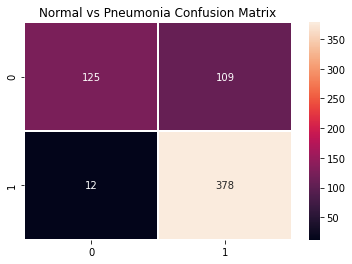

In [243]:
# plot confusion matrix
ax = plt.axes()
sns.heatmap(conf, linewidths=1, annot=True, fmt='g', ax=ax);
ax.set_title('Normal vs Pneumonia Confusion Matrix')
plt.savefig('Normal vs Pneumonia ')
plt.show();